In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *
from pathlib import Path
import cv2

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [2]:
label = [1,1,1,1,1,1,0,1,0,1,0,1,1,0,0,0,1,0,1,1,1,0,1,0,1,0,1,1,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,1,1,1,1,0,1,1,1,1,1,1,1,0,0,0,1,1,1,0,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,0,1,1,1,1,1,1,1,1,0,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,0,0,1,0,1,1,1,0,1,1,1,1,0,1,0,0,1,1,1,0,1,1,1,1,0,1,1,1,0,0,1,1,1,0,0,1,1,1,1,0,1,1,1,1,1,1,0,0,1,1,1,1,0,1,1,0,1,1,1,0,1,1,1,1,1,1,0,1,1,1,1,0,0,1,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,0,0,1,1,1,1,1,1,0,1,0,0,1,0,0,1,0,0,0,0,1,1,1,1,1,0,1,1,1,1,1,1,0,1,0,0,1,1,1,1,1,1,0,1,0,1,0,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,0,1,1,0,0,1,0,1,1,0,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,0,1,1,0,1,0,1,1,1,1,0,1,0,0,0,1,1,0,1,1,1,0,0,0,1,1,0,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,1,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,1,1,0,0,0,1,0,1,1,0,1,1,0,1,0,0]
labeltrain = label[0:240]
labeltest = label[241:301]
print(len(label))
print(labeltrain)
print(len(labeltrain))
print(labeltest)
print(len(labeltest))

373
[1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
240
[0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0]
60


## Dataset

In [3]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

train_x_arr = np.zeros(shape=(240,64,64,3),dtype=np.uint8)
train_y_arr = np.array(labeltrain)
test_x_arr = np.zeros(shape=(60,64,64,3),dtype=np.uint8)
test_y_arr = np.array(labeltest)

for itr in range(0,240):
    if Path("datasets//train//gambar-ularsq{}.jpg".format(str(itr+1))).is_file():
        imtr = cv2.imread("datasets//train//gambar-ularsq{}.jpg".format(str(itr+1)),1)
        train_x_arr[itr] = imtr
        
for itrt in range(0,60):
    if Path("datasets//test//gambar-ularsq{}.jpg".format(str(itrt+241))).is_file():
        imte = cv2.imread("datasets//test//gambar-ularsq{}.jpg".format(str(itrt+241)),1)
        test_x_arr[itrt] = imte

train_y_arrresh = train_y_arr.reshape((1, train_y_arr.shape[0]))
test_y_arrresh = test_y_arr.reshape((1,test_y_arr.shape[0]))
cur_classes = np.array([b'non snow',b'snow'])
print("train y: " + str(train_y_arrresh))
print("train x: " + str(train_x_arr))
print("test y: " + str(test_y_arrresh))
print("test x: " + str(test_x_arr))
print("classes: " + str(cur_classes))
#print(train_y)
train_x_orig = train_x_arr
train_y = train_y_arrresh
test_x_orig = test_x_arr
test_y = test_y_arrresh
classes = cur_classes

train y: [[1 1 1 1 1 1 0 1 0 1 0 1 1 0 0 0 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 0 1 0 1
  0 0 0 1 0 0 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 0 0 1 1 1 1 1 1
  1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 0 1 1 0 0 0 1 0 1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 0 0
  1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1
  0 1 1 1 1 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1
  1 0 1 0 0 1 0 0 1 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1]]
train x: [[[[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  ...

  [[0 0 1]
   [0 0 1]
   [0 0 1]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 3]
   [0 0 3]
   [0 0 3]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 3]
   [0 0 3]
   [0 0 3]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]]


 [[[4 1 0]
   [4 1 0]
   [4

[[[[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 1 0]
   [0 2 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 1 0]
   [0 2 0]]

  [[2 2 2]
   [2 2 2]
   [2 2 2]
   ...
   [2 2 2]
   [2 3 1]
   [2 3 1]]

  ...

  [[2 2 2]
   [2 2 2]
   [2 2 2]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [3 3 3]
   [3 3 3]
   [3 3 3]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]]


 [[[7 1 0]
   [7 1 0]
   [7 1 0]
   ...
   [7 0 0]
   [7 0 0]
   [7 0 0]]

  [[5 1 0]
   [5 1 0]
   [5 1 0]
   ...
   [5 0 0]
   [5 0 0]
   [5 0 0]]

  [[2 0 0]
   [2 0 0]
   [2 0 0]
   ...
   [2 0 0]
   [2 0 0]
   [2 0 0]]

  ...

  [[0 0 1]
   [0 0 1]
   [0 0 1]
   ...
   [2 0 0]
   [2 0 0]
   [2 0 0]]

  [[0 0 3]
   [0 0 3]
   [0 0 3]
   ...
   [4 0 0]
   [4 0 0]
   [4 0 0]]

  [[0 0 3]
   [0 0 3]
   [0 0 3]
   ...
   [4 0 0]
   [4 0 0]
   [4 0 0]]]


 [[[5 0 1]
   [5 0 1]
   [4 0 1]
   ...
   [0 1 0]
   [0 2 0]
   [0 2 0]]

  [[5 0

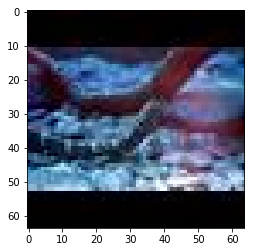

In [4]:
# Example of a picture
index = 13
plt.imshow(test_x_orig[index])
print(test_x_orig)
print(classes)
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [5]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 240
Number of testing examples: 60
Each image is of size: (64, 64, 3)
train_x_orig shape: (240, 64, 64, 3)
train_y shape: (1, 240)
test_x_orig shape: (60, 64, 64, 3)
test_y shape: (1, 60)


Ilustrasi merubah bentuk matrix dan standardisasi image sebelum masuk ke NN.

<img src="images/imvectorkiank.png" style="width:450px;height:300px;">

<caption><center> <u>Figure 1</u>: Image to vector conversion. <br> </center></caption>

In [6]:
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (12288, 240)
test_x's shape: (12288, 60)


## Architecture of the model

### 2-layer neural network

<img src="images/2layerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 2</u>: 2-layer neural network. <br> The model can be summarized as: ***INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT***. </center></caption>

### L-layer deep neural network

<img src="images/LlayerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 3</u>: L-layer neural network. <br> The model can be summarized as: ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***</center></caption>

### General methodology

    1. Initialize parameters / Define hyperparameters
    2. Loop for num_iterations:
        a. Forward propagation
        b. Compute cost function
        c. Backward propagation
        d. Update parameters (using parameters, and grads from backprop) 
    4. Use trained parameters to predict labels

## Two-layer neural network

In [7]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [8]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        A1, cache1 = linear_activation_forward(X, W1, b1, 'relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, 'sigmoid')
        
        # Compute cost
        cost = compute_cost(A2, Y)
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, 'sigmoid')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, 'relu')
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.6930287359380648
Cost after iteration 100: 0.6074108054368004
Cost after iteration 200: 0.5911078127459033


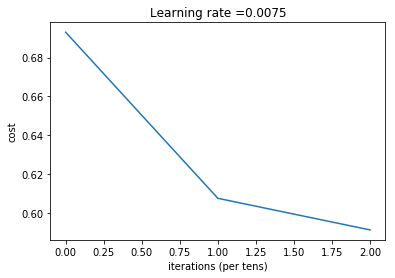

In [9]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

In [10]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.6875


In [11]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.7000000000000001


## Test with your own image ##

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  """
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


Accuracy: 1.0
y = 1.0, your L-layer model predicts a "snow" picture.


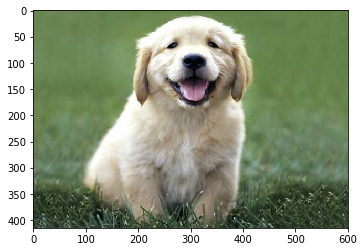

In [12]:
my_image = "smileypup.jpg" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)

fname = my_image#"images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((num_px*num_px*3,1))
my_image = my_image/255.
my_predicted_image = predict(my_image, my_label_y, parameters)

plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")